# Introduction

Welcome to the third lab. There is much to go through today so we will keep extra concepts to a minimum. There is no new library introduced at this lecture as we will keep using `numpy` for the heavy lifting, `scikit-learn` for the algorithms, and `seaborn` / `matplotlib` for plotting. Careful about reusing variable names in the notebook and computing cells out of order: frequent calls to `Kernel -> Restart and Run All` can save you from headaches.

The assignment starts getting math-heavy. Here's a new tool to aid you with the debugging. Explicitly `import IPython` at the beginning of a notebook (or Python file) to have access to the computational Python kernel. You can then call `IPython.embed()` at an arbitrary place in your code (say, inside a loop) and it will pause the computation and drop you into an interactive console. You can then evaluate Python code in the context where it was called. Here is an example:

```python
import numpy as np
for i in range(10):
    guess = np.random.normal()
    function_that_fails_because_of(guess, i)
```

Let's say your function fails for `i==9`, how would you find the error? Typically you may want to edit the code and print `guess` and `i` to see what is happening, but it is slow and passive. What if you want to try to pass `i+1` and see if that works? What if you want to try a few other random numbers with the same `i`? Enter `IPython.embed()`:

```python
import numpy as np
import IPython
for i in range(10):
    guess = np.random.normal()
    if i==9: IPython.embed()
    function_that_fails_because_of(guess, i)
```

If you execute this code, the cell output will show an interactive console in your output cell. Here you can send commands to be interpreted by the Python kernel of the notebook. You could then try something like the following lines for example (one at a time):

```python
i #=> prints value of i
guess  #=> prints value of guess
function_that_fails_because_of(guess, i) #=> fails and shows you the error
function_that_fails_because_of(guess, i+1) #=> change parameters: will it work?
function_that_fails_because_of(guess, i-1) #=> what about this one?
guess = np.random.normal() #=> overwrites the value of `guess` in the kernel
function_that_fails_because_of(guess, i) #=> will this work this time?
```

As you can see you can test your code in the context of the function (or, here, loop), find the code that works, then you can go ahead and copy+paste in your actual code. If you need to exit the console and resume the computation (with whatever change you executed, as the kernel is the same) just type `exit()`.

_Bonus:_ you can ask the kernel to drop you into a _debugger_ session every time you get an error. This can be tricky with Jupyter Notebooks, so use with caution, but can also be a lifesaver if you are willing to learn about [postmortem debugging](https://medium.com/instamojo-matters/become-a-pdb-power-user-e3fc4e2774b2). You do that by adding the following lines on top of your code (need to execute them only once):

```python
# DEBUG: uncaught exceptions drop you into ipdb for postmortem debugging
import sys, IPython; sys.excepthook = IPython.core.ultratb.ColorTB(call_pdb=True)
```

After this line, if you encounter an error or uncaught exception in your code, rather than terminating you will be dropped in an `ipdb` (fancier version of `pdb`) console where you can interrogate the program about the conditions causing the crash.

Good hunting!

# 1. Fundamentals

Let's make sure some of the core points are clear before addressing the specific algorithms.

#### 1.1 **[1pt]** Write the equation of the Gaussian density. Use Latex inside the Markdown cell.

I suggest you type it out rather than copy+paste from the Internet: the goal of this question is to _force_ you to read one term at a time, and understand which is clear to you and which is not.
For example, the equation you will write here a norm, while our later applications of the formula do not, since we will actually be using the [Gaussian](https://en.wikipedia.org/wiki/Normal_distribution) Probability Density Function [(PDF)](https://en.wikipedia.org/wiki/Probability_density_function) equation instead. Do you understand why? Did you study this before?

Gaussian density (pdf): $f(x) = \frac{1}{\sqrt(2\pi)\sigma} exp[-\frac{1}{2}(\frac{x-\mu}{\sigma})^2]$

#### 1.2 **[1pt]** Explain why we maximize the log-likelihood rather than the likelihood. In particular, what is the advantage in using the $\log$ rather than another operation?

The likelihood (probability distribution) of finding target Y given the available data is a product of likelihood that the output is drawn as random variable from the distribution. However, the loglikelihood maximum pose a challenge when it comes to maximize the product. Therefore, logarithm transformation will outperform that is easier to maximize the sum than the product.

#### 1.3 **[1pt]** Why the equation maximizing the log-likelihood of a Gaussian does not include the parameter $\sigma$?

$\sigma$ is a constant term that do not depend on $w$ therefore it can be dropped out of the maximization equation

#### 1.4 **[1pt]** Explain the meaning of i.i.d. (in English), using the simplest words you can.

i.i.d stands for identical independent distribution means that random variables drawn from that distribution do not influence each other.

#### 1.5 **[2pt]** Write the equation of the Bayes' Rule (use Latex). Then write below how to read it in English.

$P(y|x) = \frac{P(x|y).P(y)}{P(x)}$

As Bayes theorem, probability of class y given the input x equals to probability of joint distribution of x and y (which is the product of probability x given y and unconditional probability of y- we call it as prior probability) divided by unconditional probability of x. 

# 2. Linear Regression

#### 2.1 **[2pt]** Explain the meaning of $y_i = \langle w, x_i \rangle + \epsilon_i, \;\; \epsilon \sim \mathcal{N}(0, \sigma^2)$ (in English). Utilize the word 'prototype'.

The label $y_i$ of an input $x_i$ can be interpreted as class prototype $\langle w, x_i \rangle$ plus a certain error $\epsilon$ drawn from Gaussian with mean 0 and variance $\sigma^2$.
The inverse also is true, as obvious by swapping the side of $\epsilon$ in the equation: the prototype predicted by the model $\langle w, x_i \rangle$ correspond to the exact label $y_i$ plus some noise $\epsilon_i$

Enough theory, let's get our hands in there. Since we are working with a regression task, let us generate some data from an underlying linear function with some noise.  
_[think: the process below is (correct but) unnecessary convoluted: would you be able (yet) to simplify it? Always prefer simpler code!]_

In [52]:
import numpy as np
trg_fn = lambda x: 2*x - 1 # hi I'm lambda, remember me?
some_noise = lambda: np.random.normal(0,2) # Gaussian noise with mu=0, sigma=2

# Below we add a 1 to every row as the bias (constant) input
# Think about each part and discuss if you do not understand something yet!
data = np.array([[x, 1, trg_fn(x) + some_noise()] for x in np.linspace(-10, 10, 50)])
#print(data.transpose())
*x, y = data.transpose() # easier using splat and numpy: do you understand it?
x = np.array(x).transpose() # back to *rows* with input features and bias input
print(x)

[[-10.           1.        ]
 [ -9.59183673   1.        ]
 [ -9.18367347   1.        ]
 [ -8.7755102    1.        ]
 [ -8.36734694   1.        ]
 [ -7.95918367   1.        ]
 [ -7.55102041   1.        ]
 [ -7.14285714   1.        ]
 [ -6.73469388   1.        ]
 [ -6.32653061   1.        ]
 [ -5.91836735   1.        ]
 [ -5.51020408   1.        ]
 [ -5.10204082   1.        ]
 [ -4.69387755   1.        ]
 [ -4.28571429   1.        ]
 [ -3.87755102   1.        ]
 [ -3.46938776   1.        ]
 [ -3.06122449   1.        ]
 [ -2.65306122   1.        ]
 [ -2.24489796   1.        ]
 [ -1.83673469   1.        ]
 [ -1.42857143   1.        ]
 [ -1.02040816   1.        ]
 [ -0.6122449    1.        ]
 [ -0.20408163   1.        ]
 [  0.20408163   1.        ]
 [  0.6122449    1.        ]
 [  1.02040816   1.        ]
 [  1.42857143   1.        ]
 [  1.83673469   1.        ]
 [  2.24489796   1.        ]
 [  2.65306122   1.        ]
 [  3.06122449   1.        ]
 [  3.46938776   1.        ]
 [  3.87755102

#### 2.2 **[1pt]** Write a (Python) function that takes a data point in input and returns the squared error Loss. Test it by using a constant prediction model $y = 1$ and compute the Risk over all the data.

In [2]:
def sqr_loss (pred, trg):
    return np.power(pred-trg, 2)

risk = sum(sqr_loss(pred= 1,trg= target) for target in y)
print(f"Risk over all the data: {risk}")
    

Risk over all the data: 7066.617507446761


[IMPORTANT]: A few tips before we proceed:
- Numpy's linear algebra library provides matrix inversion, but you should use instead the pseudo-inverse to cope with singular covariance matrices: `np.linalg.pinv()`
- Numpy's array provides inner product with the function `dot()`
- Typically `dot()` will find the right direction for one-dimensional arrays, which means that you should never need to transpose them
- Using `dot()` with matrices instead *always* requires you to `transpose()` to the right orientation! Write the math and keep track of what you are doing.
- Remember that matrix product is not commutative: `A.dot(B)` is NOT equal to `B.dot(A)`. Refresh also how `A.dot(B)` requires the number of columns of `A` to be the same as the number of rows of `B`, and the result will have the same number of rows of `A` and the number of columns of `B`.
- Linear regression uses a closed-form solution, **not a loop**, and you will not use the implementation of the loss above in the rest of the assignment (because it is implicit in the algorithm's solution).

#### 2.3 **[2pt]** Write a function that takes in input a list of data points and a list of labels, and returns the $w$ vector using the closed-form solution of Linear Regression. Test it on the data above and print the computed $w$.

The solution of $w$ in closed-form is $w = (X^TX)^{-1} X^T.y$ with $y\in R^n$ is vector of target for each input. $X \in R^{nxp}$ input data matrix

In [33]:
def solution_w (x, y):
    #return np.dot(np.dot(np.linalg.pinv(np.dot(x.transpose(), x)), x.transpose()), y) #give the same result
    return np.linalg.pinv(x.transpose().dot(x)).dot(x.transpose()).dot(y)  
w = solution_w(x, y)
print(w)
print(w.shape)

[ 1.97006272 -0.75758749]
(2,)


#### 2.4 **[2pt]** Predict the labels for all points using your Linear Regression implementation and the `w` vector from the previous question. For each data point, print the triplet of  `(label, prediction, loss)`. Then compute and print the (squared error) Risk over the dataset.

Remember that you need to build the linear model (careful handling the bias), then you are doing _regression_ not *classification*, which means you are predicting the value $\hat{y}$ based on your $x$. You should get back $m$ and $q$ close to $2$ and $-1$, and the risk roughly proportional to the square of the expected error multiplied by the number of points (or close below that).  
_[think: what is the expected error? Do you understand why? You can generate the points and compute the risk multiple times to verify your hypothesis]_

In [43]:
predictions = list(map(round, w.dot(x.transpose())))
#print(predictions)

losses = list(sqr_loss(pred, trg) for pred, trg in list(zip(predictions, y)))
#print(losses)

triplets = list(zip(y, predictions, losses))
print(triplets)

Risk= sum(losses)
print (f"\nRisk is sum of losses over the dataset." 
       f"For trained predictor: 'y = {round(w[0],2)}x + {round(w[1],2)}' using squared error loss: {round(Risk,2)}")


[(-20.80930293408694, -20, 0.6549712391217299), (-16.498918550624992, -20, 12.257571315157804), (-17.814783457782287, -19, 1.404738251946512), (-16.83936382386161, -18, 1.3470763333611426), (-18.47961744971629, -17, 2.1892677975049386), (-15.335986571592331, -16, 0.4409138331057067), (-19.235191822130194, -16, 10.466466125978082), (-13.650776750267235, -15, 1.820403377619442), (-15.860297866624183, -14, 3.4607081525664873), (-9.405033657212261, -13, 12.92378300577665), (-12.558224100014431, -12, 0.311614145836922), (-11.278773538006027, -12, 0.5201676094803445), (-12.747082210045418, -11, 3.0522962486571825), (-11.565693990948583, -10, 2.4513976732925022), (-8.55945304885273, -9, 0.19408161616515562), (-6.745559748541925, -8, 1.5736203444781973), (-5.2094987358540745, -8, 7.786897305200008), (-6.762075042802078, -7, 0.05660828525763315), (-6.385148271148063, -6, 0.14833919076834198), (-5.74291229790813, -5, 0.5519186823831377), (-7.308609389419532, -4, 10.946896091755088), (-5.88999172

#### 2.5 **[2pt]** Plot the data and the model.

You should be able to partially reuse the printing code from the last lab (particularly plot and params-to-boundary conversion), but feel free to customize it as you need.
I will keep repeating this for a while more: careful with the bias!  
(Think: you can plot the model's predictions very easily if you use linear algebra, do you understand what is `x.dot(w)`?)

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")

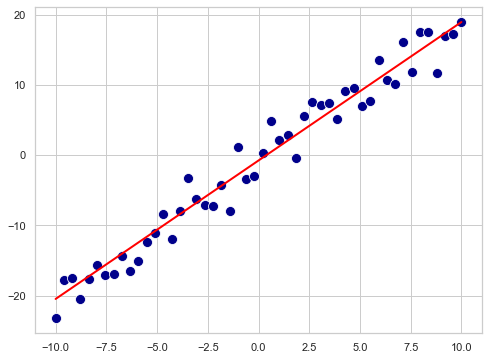

In [81]:
actual_x,bias = x.transpose()
#print(actual_x)               #actual_x is a 1D array (1xn matrix)
#print(actual_x.reshape(-1,1)) #forcing into nx1 matrix
#print(actual_x.transpose())   #for 1D array, transpose has no effect, you can check it's equal to actual_x

def dataplot():
    sns.scatterplot(x=actual_x, y=y, color='darkblue', s= 100)
dataplot()
def modelplot(w, color):
    sns.lineplot(x= actual_x, y= x.dot(w), color= color, linewidth= 2) 
modelplot(w, 'red')

#### 2.6 **[2pt]** Find Linear Regression in scikit-learn and train a model on the data.

The input to the `fit()` function should be a matrix and a vector, so try forcing `actual_x` into a $n\times 1$ matrix by using `actual_x.reshape((-1, 1))`. If you want to predict the outputs, you simply need to pass the same data matrix to the method `predict()`.  

In [66]:
from sklearn.linear_model import LinearRegression

x_matrix = actual_x.reshape(-1,1)

model= LinearRegression()
trained= model.fit(x_matrix, y)
pred = trained.predict(x_matrix)

#### 2.7 **[1pt]** Plot in a single figure: (i) the data points as a scatterplot; (ii) the model you learned using your implementation of Linear Regression; (iii) the model you trained using the scikit-implementation.

Careful, it may be that you plot both but they are exactly the same, so they are superimposed and you only see one line. To verify this you can try plotting them with different colors and different thickness, or changing the linestyle (e.g. one normal line and one dashed line). A list of available linestyles can be found in the [matplotlib documentation](https://matplotlib.org/3.5.1/gallery/lines_bars_and_markers/linestyles.html).

To get the parametrization of the sklearn implementation use the following:  
`w_skl = [trained.coef_[0], trained.intercept_]`  
Do you understand what this does? Can you see how this corresponds to what we did last week? In future assignments you will need to find the model parametrization by yourself!

[2.005293613710683, -0.9407859956476605]


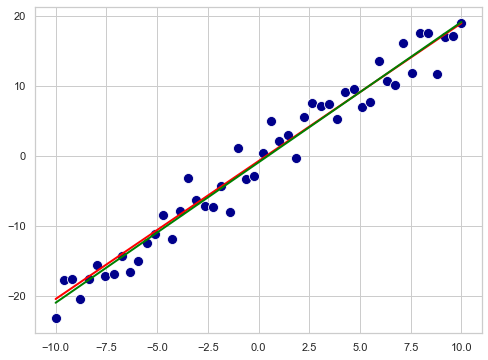

In [82]:
dataplot()
modelplot(w, 'red')  #model learned using implementation of Liner Regression

w_skl = [trained.coef_[0], trained.intercept_]    #w_skl = [w,b]
print(w_skl)
modelplot(w_skl, 'green')   #model trained using scikit-implementation

# 3. Linear Discriminant Analysis

We switch now into *binary classification*. Let's load the iris dataset once again for this exercise, and carefully selecting the data to have an easy binary classification problem (for now). Notice we are **not** using classes ${-1, +1}$ anymore, because we do not need to compute a Margin here.

In [87]:
import numpy as np
from sklearn.datasets import load_iris
iris_x, iris_y = load_iris(return_X_y=True) # print these points to understand them!

x1 = np.array([r[0] for r in iris_x]) # first feature
x2 = np.array([r[2] for r in iris_x]) # third feature

x = np.array([x1, x2]).transpose() # numpy gives us transpose() for free

# Reduce the three classes into two for binary classification {1, 2}
y = np.array([1 if y in [1,2] else 2 for y in iris_y])

[[5.1 1.4]
 [4.9 1.4]
 [4.7 1.3]
 [4.6 1.5]
 [5.  1.4]
 [5.4 1.7]
 [4.6 1.4]
 [5.  1.5]
 [4.4 1.4]
 [4.9 1.5]
 [5.4 1.5]
 [4.8 1.6]
 [4.8 1.4]
 [4.3 1.1]
 [5.8 1.2]
 [5.7 1.5]
 [5.4 1.3]
 [5.1 1.4]
 [5.7 1.7]
 [5.1 1.5]
 [5.4 1.7]
 [5.1 1.5]
 [4.6 1. ]
 [5.1 1.7]
 [4.8 1.9]
 [5.  1.6]
 [5.  1.6]
 [5.2 1.5]
 [5.2 1.4]
 [4.7 1.6]
 [4.8 1.6]
 [5.4 1.5]
 [5.2 1.5]
 [5.5 1.4]
 [4.9 1.5]
 [5.  1.2]
 [5.5 1.3]
 [4.9 1.4]
 [4.4 1.3]
 [5.1 1.5]
 [5.  1.3]
 [4.5 1.3]
 [4.4 1.3]
 [5.  1.6]
 [5.1 1.9]
 [4.8 1.4]
 [5.1 1.6]
 [4.6 1.4]
 [5.3 1.5]
 [5.  1.4]
 [7.  4.7]
 [6.4 4.5]
 [6.9 4.9]
 [5.5 4. ]
 [6.5 4.6]
 [5.7 4.5]
 [6.3 4.7]
 [4.9 3.3]
 [6.6 4.6]
 [5.2 3.9]
 [5.  3.5]
 [5.9 4.2]
 [6.  4. ]
 [6.1 4.7]
 [5.6 3.6]
 [6.7 4.4]
 [5.6 4.5]
 [5.8 4.1]
 [6.2 4.5]
 [5.6 3.9]
 [5.9 4.8]
 [6.1 4. ]
 [6.3 4.9]
 [6.1 4.7]
 [6.4 4.3]
 [6.6 4.4]
 [6.8 4.8]
 [6.7 5. ]
 [6.  4.5]
 [5.7 3.5]
 [5.5 3.8]
 [5.5 3.7]
 [5.8 3.9]
 [6.  5.1]
 [5.4 4.5]
 [6.  4.5]
 [6.7 4.7]
 [6.3 4.4]
 [5.6 4.1]
 [5.5 4. ]
 [5.5 4.4]

To solve LDA we need to find the parametrization $\theta_y=(\mu_y, \Sigma, \pi_y)$. Since $\mu$ and $\pi$ are class-dependent, remember to first split the input data based on which class it belongs to.

#### 3.1 **[1pt]** Write a (Python) function that takes a dataset (inputs and labels) in input and returns a dictionary hashing each of the $m$ classes to the a list of the points belonging to that class. We will call this `partition` in the next questions.

Hint: the method `dict.get(<key>, <def>)` can be used to fetch values from a dictionary same as `dict[<key>]`, but when the key is not found it returns the second argument, which is the _default value_... what if you pass an empty list...

In [91]:
def partition_dset(inputs, classes):
    ret = {}
    for inp, cls in zip(inputs, classes):
        ret[cls] = ret.get(cls, [])+[inp]   #structure of ret would be like {class: inputs belonged}
    return ret

part = partition_dset(x, y)
print(part)

{2: [array([5.1, 1.4]), array([4.9, 1.4]), array([4.7, 1.3]), array([4.6, 1.5]), array([5. , 1.4]), array([5.4, 1.7]), array([4.6, 1.4]), array([5. , 1.5]), array([4.4, 1.4]), array([4.9, 1.5]), array([5.4, 1.5]), array([4.8, 1.6]), array([4.8, 1.4]), array([4.3, 1.1]), array([5.8, 1.2]), array([5.7, 1.5]), array([5.4, 1.3]), array([5.1, 1.4]), array([5.7, 1.7]), array([5.1, 1.5]), array([5.4, 1.7]), array([5.1, 1.5]), array([4.6, 1. ]), array([5.1, 1.7]), array([4.8, 1.9]), array([5. , 1.6]), array([5. , 1.6]), array([5.2, 1.5]), array([5.2, 1.4]), array([4.7, 1.6]), array([4.8, 1.6]), array([5.4, 1.5]), array([5.2, 1.5]), array([5.5, 1.4]), array([4.9, 1.5]), array([5. , 1.2]), array([5.5, 1.3]), array([4.9, 1.4]), array([4.4, 1.3]), array([5.1, 1.5]), array([5. , 1.3]), array([4.5, 1.3]), array([4.4, 1.3]), array([5. , 1.6]), array([5.1, 1.9]), array([4.8, 1.4]), array([5.1, 1.6]), array([4.6, 1.4]), array([5.3, 1.5]), array([5. , 1.4])], 1: [array([7. , 4.7]), array([6.4, 4.5]), ar

#### 3.2 **[1pt]** Write a function that takes the `partition` in input and returns a dictionary hashing each class to its corresponding prototype $\mu_y$.

Hint: function `dict.items()` returns a list of pairs `(key, value)` from the dictionary.
Then a _dictionary comprehension_ works same as a list comprehension, with a `for` loop that generates elements. Only this time you need to pass both a key and a value like this:
```python
d = { the_key: compute_value(a, b) for a, b in another_dict.items() }
```
If you can use that then the answer is basically one line. If it is complicated instead, write explicit `for` loops, which are exactly equivalent (and perhaps even more readable:
```python
d = {}
for a, b in another_dict.items():
    d[the_key] = compute_value(a, b)
```
Just find a style that is comfortable with you. May take a few weeks but you will get there.

In [99]:
#a dict hashing each class to its corresponding prototype - class-wise centers
def lda_mu (part):
    d_mu = {}
    for cls, pts in part.items():
        d_mu[cls] = sum(pts)/len(pts)  #class center = average the inputs in a class
    return d_mu

#Alternative:
#def lda_mu (part): return {cls: sum(pts)/len(pts) for cls, pts in part.items()}

mu = lda_mu(part)

[5.006 1.462]
[5.006 1.462]


#### 3.3 **[1pt]** Write a function that takes the `partition` in input and returns a dictionary hashing each class to its corresponding prior $\pi_y$.

In [92]:
def lda_pi (part):
    tot_len = sum(map(len, part.values()))    #map all the lengths and sum
    return {cls: len(pts)/tot_len for cls, pts in part.items()}
pi = lda_pi(part)
print(pi)

{2: 0.3333333333333333, 1: 0.6666666666666666}


#### 3.4 **[4pt]** Write a function that takes the `partition` in input and the class-wise center estimates (the means from above) and returns the corresponding $\Sigma$ (one for all classes and all inputs).
You may need to use `np.concatenate()` to join the $x_i - \hat{\mu}_{y_i}$ from each class. Print the `array.shape` (property not method so no `()`) to verify if your linear algebra is on point so far: the covariance matrix between all inputs should have as many rows (and columns) as the number of features (hint: that's 2). Example: `assert sigma.shape == (2,2)` should not raise an error.

In [95]:
def lda_sigma (part, mu):
    diff = np.concatenate([pts-mu[cls] for cls, pts in part.items()])  #np.concatenate() to join the diff from each class
    return np.dot(diff.transpose(),diff)/len(diff)

sigma = lda_sigma(part, mu)
assert sigma.shape == (2,2)

#### 3.5 **[5pt]** Write the function for the decision boundary of LDA $f(x)$.

You can find the logarithm in the `math` module: `from math import log` then just `l = log(a)`. You need to implement the equations for $w$ and $q$ from the slides: this cell will be very math heavy, be careful though and you should be able to get it right in few lines. Remember to check for the shape of $w$ and $b$ to verify if your matrix products are computed the right way. You want $w$ to be of length 2, and $b$ is a scalar.

In [103]:
from math import log
sigma_inv= np.linalg.pinv(sigma)
w = sigma_inv.dot(mu[1]-mu[2])
b = 0.5*mu[2].dot(sigma_inv).dot(mu[2]) - \
    0.5*mu[1].dot(sigma_inv).dot(mu[1]) + \
    log(pi[1]) - log(pi[2])

print(f"w: {w} \nb: {b}")
 
f = lambda x: w.dot(x) + b

w: [-7.96528842 12.76916894] 
b: 4.912548207950932


#### 3.6 **[2pt]** Plot the LDA decision boundary on top of the data.

- Notice that we are using different data from the Linear Regression questions above, and that our model now generated $w$ and $b$ separately, so you **need** to adapt the plotting functions -- actually it's quicker to just rewrite them.
- Plotting is one of few applications where generalizing your code just makes for a stunted replica of the original (better) interface, so specialize when needed but for different applications just write a new one rather than reusing your code.
- Remember that we already had a good plotting function for a classification problem just last week, why don't you check it out again?
- Finally, remember that you already have code that converts a parametrization from $w$ and $b$ to $m$ and $q$ (last assignment), you can simply copy+paste it here to simplify your generation of the model's points.

m: 0.6237906674023638, q: -0.38471949350071843


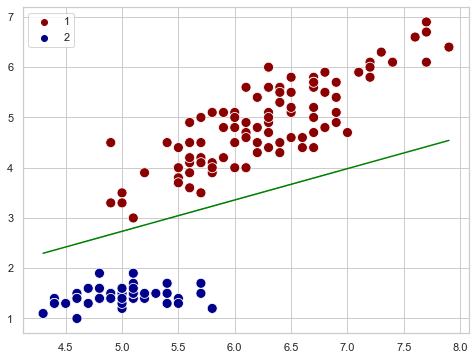

In [112]:
#Convert a parametrization from w,b to m,q:
def wb2mq(w, b):
    assert len(w) == 2, "This implementation only works in 2D"
    assert w[0] != 0 and w[1] != 0 and b != 0 # avoid edge cases for now
    return [w[0]/-w[1], b/-w[1]] # here are m and q

def params2boundary(w, b):
    m, q = wb2mq(w, b)
    print(f"m: {m}, q: {q}")
    return lambda x: m*x + q

#Plotting functions:
def lda_data_plot(): 
    sns.scatterplot(x=x1, y=x2,
        hue= y, # let's use different colors for the two classes
        palette = sns.color_palette(['darkred','darkblue']),
        s=100)

def lda_model_plot(w,b, color):
    model = params2boundary(w,b)
    sns.lineplot(x= x1, y= [model(inp) for inp in x1], color= color) 

lda_data_plot()
lda_model_plot(w,b, "green")


#### 3.7 **[1pt]** Find LDA on scikit-learn; train a model on the data and add it to the print above (data + model from your implementation).

You ned to pass the correct `solver` parameter to the sklearn constructor, check the documentation to understand what I mean. If you do not the result should still look exactly the same as your implementation (because the data is linearly separable), but you should be aware of which technique your library uses and we have not gotten to SVD yet.  
Remember to make sure that you can distinguish the two boundaries even if they overlap (e.g. use different colors). If you use our conversions from last exercise you should also see the printed values of $m$ and $q$ and they are likely to differ in the least significant digits even though the graph looks the same.  
Also consider that LDA is a **multiclass method**, and so its parametrization is in principle a list for the many boundaries: you need to access the coefficients of the _first_ (and here, only) boundary using `[trained_model.coef_[0], trained_model.intercept_[0]]`.

x shape: (150, 2), y shape: (150,)
m: 0.6237906674023639, q: -0.3847194935007168


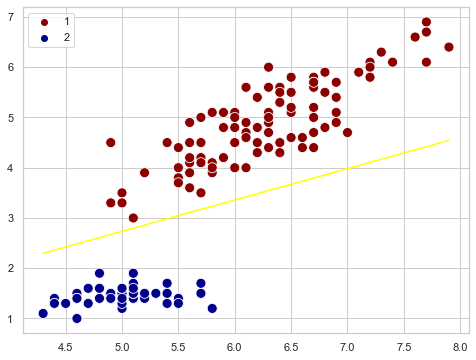

In [114]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
print(f"x shape: {x.shape}, y shape: {y.shape}")

model = LinearDiscriminantAnalysis('lsqr')
trained = model.fit(x,y)

w_skl, b_skl = [trained.coef_[0], trained.intercept_[0]]
lda_data_plot()
lda_model_plot(w,b, "green")
lda_model_plot(w_skl,b_skl, "yellow")#You can see 2 boundaries are overlapped by green & yellow

## At the end of the exercise

Bonus question reward no points! Answering this will have no influence on your scoring, not at the assignment and not towards the exam score. But solving it will reward you with skills that will make the next lectures easier, give you real applications, and will be very good practice towards the exam.

The solution for this questions will not be included in the regular lab solutions pdf, but you are welcome to open a discussion on the Moodle: we will support your addressing it, and you may meet other students that choose to solve this, and find a teammate for the next assignment that is willing to do things for fun and not only for score :)

Let's see some multiclass classification. Copy the code loading the Iris dataset, you want to extract the same features (so you can plot in 2D), but keep the three classes.  
_[think: does it matter what label does each class have? Could you use strings such as `['a', 'b', 'c']`?]_  
Then run the scikit-learn LDA on the data to obtain a trained model. At this point you can open up the trained coefficients again, and rather than taking only the first like you did with `[trained.coef_[0], trained.intercept_[0]]`, you should have TWO $w$ vectors and TWO $b$ constants **per each pair** of classes.
_[think: the space is actually split in several subspaces. Can you derive how many? Can you design a decision tree on top of the boundaries to do the classification as the number of boundaries grow?]_

#### BONUS **[ZERO pt]** Plot the boundaries classifying the three species of Iris in the dataset based on the two features used so far.

### Final considerations

Stop for a moment and think how hard it was to derive these equations (in the lecture), and how hard it was instead to implement them (once you get them right). These are two very different skills.  
To understand the derivation you need to think hard, express your concept in math (actually requiring broad knowledge of many of its subfields), see it through with absolute precision, and finally correctly solve the equations.  
To implement the method, you need to map the math to the correct function calls (hard, but arguably less), and you only ever work with the final solution, but you deal with programming languages and libraries and documentations.  
This is the reason why so many people nowadays broadly advertise machine learning skills after taking short tutorials. But if you do not understand what a parameter is for, you will only be guessing which value to use.

The reason why you are sweating so much on this course is to gain an edge over all of those who only ever learn to _use_ the tools: by instead _making_ the tools you understand them from the inside out, their applications and limitations, and even become capable of adapting and improving them.  
Keep up: this course is not easy, but machine learning has become unavoidable in your field, and these foundations will enable you to bend the whole field to your needs.